In [1]:
import vit
from load_dataset import Yoga82
from verify_dataset import verify_dataset, calculate_mean_std, load_from_file, get_class_list
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# Setting Config Dict
config = {
    "num_classes": 82,
    "img_size": 128,
    "img_channels": 3,
    "patch_size": 16,
    "hidden_size": 1024,
    "num_hidden_layers": 6,
    "num_attention_heads": 6,
    "mlp_hidden_size": 2048,
    "initializer_range": 0.02,
}
learning_rate = 8e-6
betas = (0.9, 0.999)
weight_decay = 0.3
batch_size = 128
device = 'cuda'
epochs = 200

In [3]:
# Verify Dataset (may take a while :'c)
# images, labels, cls_names = verify_dataset()

In [4]:
images, labels = load_from_file()
cls_names = get_class_list()

Dataset Total: 20107
Total Classes: 82


In [5]:
# Prepare Dataset
X_train, left_images, y_train, left_labels = train_test_split(images, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(left_images, left_labels, test_size=0.5, random_state=42)

#mean, std = calculate_mean_std(X_train)
mean = [0.6692247, 0.64782774, 0.6202068]
std = [0.23499408, 0.23690693, 0.23922563]

print("Mean:", mean)
print("Std:", std)

transform = transforms.Compose([
    transforms.Resize((config['img_size'], config['img_size'])),
    #transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_dataset = Yoga82(X_train, y_train, transform=transform)
val_dataset = Yoga82(X_val, y_val, transform=transform)
test_dataset = Yoga82(X_test, y_test, transform=transform)

Mean: [0.6692247, 0.64782774, 0.6202068]
Std: [0.23499408, 0.23690693, 0.23922563]


In [6]:
#Create model and training parameters
model = vit.ViT(config).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [7]:
#checkpoint = torch.load('model_checkpoint_epoch_28.pth')
#model.load_state_dict(checkpoint['model_state_dict'])

In [9]:
#1:41
import numpy as np
import torch
import torch.nn as nn
import wandb
from tqdm import tqdm

# Initialize WandB
wandb.init(project='yoga82-vit', name='run')
loss_values = []
avg_loss_values = []
model.train()

# Training loop
for epoch in range(epochs):
    losses_per_epoch = []
    for batch in tqdm(train_dataloader):
        inputs, targets = batch
        inputs, targets = inputs.cuda(), targets.cuda()

        # Your training logic here
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_values.append(loss.item())
        losses_per_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        # Log metrics to WandB
        
    avg_loss = np.mean(losses_per_epoch)
    wandb.log({'epoch': epoch, 'loss': avg_loss.item()})
    avg_loss_values.append(avg_loss)

    # Save the model checkpoint after each epoch
    checkpoint_path = f"model_checkpoint_epoch_{epoch + 1}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }, checkpoint_path)

    print(f"Epoch {epoch + 1} - Loss: {avg_loss.item()} - Model checkpoint saved to {checkpoint_path}")

# Optionally, save the model
wandb.save('your_model.pth')

print("Training completed.")

epoch,▁█
loss,█▁
epoch,1
loss,4.31732


  0%|          | 0/95 [00:00<?, ?it/s]c:\Users\felip\anaconda3\envs\vit\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 95/95 [02:43<00:00,  1.72s/it]


Epoch 1 - Loss: 4.292696465943989 - Model checkpoint saved to model_checkpoint_epoch_1.pth


 17%|█▋        | 16/95 [00:31<02:37,  1.99s/it]


KeyboardInterrupt: 

In [25]:
import numpy as np

for loss in loss_values:
    if np.isnan(loss):
        print(True)

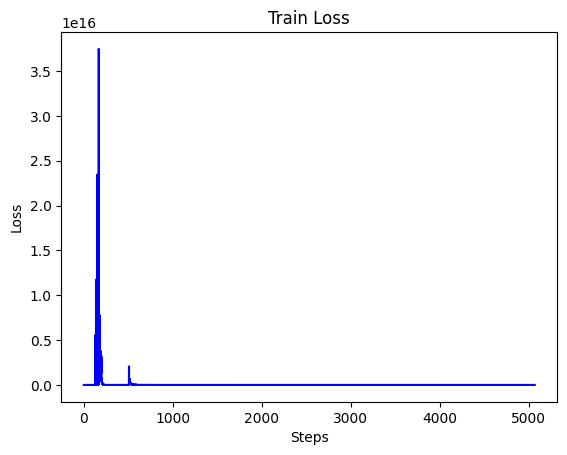

In [9]:
loss_values = [loss.detach().cpu().numpy() for loss in loss_values]
plt.figure()
plt.title("Train Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.plot(loss_values,label='Train Loss',color='blue')

In [20]:
# Function to display the Loss Curve
def loss_display(epochs,train_loss,valid_loss=None,model_name=""):
  plt.figure()
  plt.title(model_name+" Train Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(range(epochs),train_loss[:epochs],label='Train Loss',color='blue')
  if valid_loss!=None:
    plt.plot(range(epochs),valid_loss[:epochs],label='Valid. Loss',color='red')
    plt.title(model_name+"\n Train and Validation Loss")
  plt.legend()

In [9]:
checkpoint = {
    'model_state_dict': model.state_dict(),
}
torch.save(checkpoint, f'model_checkpoint.pth')

In [8]:
## Training loop with checkpointing
#from tqdm import tqdm
#from torch.cuda.amp import autocast, GradScaler
#
#epochs = 5
#with autocast():
#    for epoch in range(epochs):
#        for batch in tqdm(train_dataloader):
#            # Forward pass
#            inputs = batch[0].to(device)
#            labels = batch[1].to(device)
#            outputs = model(inputs)
#            loss = criterion(outputs, labels)
#
#            # Backward pass and optimization
#            optimizer.zero_grad()
#            scaler.scale(loss).backward()
#            scaler.step(optimizer)
#            scaler.update()
#
#        print(f'End of Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
#
#        # Save a checkpoint after each epoch
#        checkpoint = {
#            'epoch': epoch + 1,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss.item(),
#        }
#        torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
#
#    print("Training finished.")

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
from tqdm import tqdm
# Acc. and Conf. Matriz function
def model_analysis(model,dataloader,device='cuda',model_name='',dataset_name=None,conf_matrix=True,cmap="rainbow",figsize=25):
  model.eval()
  y_batch_pred=[]
  y_batch_true=[]
  with torch.no_grad():
    for data in tqdm(dataloader):
      inputs = data[0].to(device)
      labels = data[1].to(device)
      outputs = model(inputs)
      #Compute accuracy
      smax = nn.LogSoftmax(dim=1)
      pred = torch.argmax(smax(outputs),dim=1)
      y_batch_pred.append(pred.tolist())
      y_batch_true.append(labels.tolist())
  y_pred = np.concatenate(y_batch_pred)
  y_true = np.concatenate(y_batch_true)
  acc = metrics.accuracy_score(y_true,y_pred,normalize=True)
  if dataset_name!=None:
    print('\n{} Accuracy for {}: {}'.format(model_name,dataset_name,acc))
  else:
    print('\n{} Accuracy: {}'.format(model_name,acc))

  #Confusion Matrix Plot
  if conf_matrix:
    conf_mat = metrics.confusion_matrix(y_true,y_pred,normalize='true')
    plt.figure(figsize=(figsize,figsize))
    cfm_plot = sns.heatmap(conf_mat,cmap=cmap,annot=True)
    if dataset_name!=None:
      plt.title('{} \n Confusion Matrix for {}'.format(model_name,dataset_name))
    else:
      plt.title('{} \n Confusion Matrix'.format(model_name))

  return acc

  0%|          | 0/16 [00:00<?, ?it/s]c:\Users\felip\anaconda3\envs\vit\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 16/16 [09:40<00:00, 36.27s/it]



 Accuracy: 0.011102886750555145


0.011102886750555145

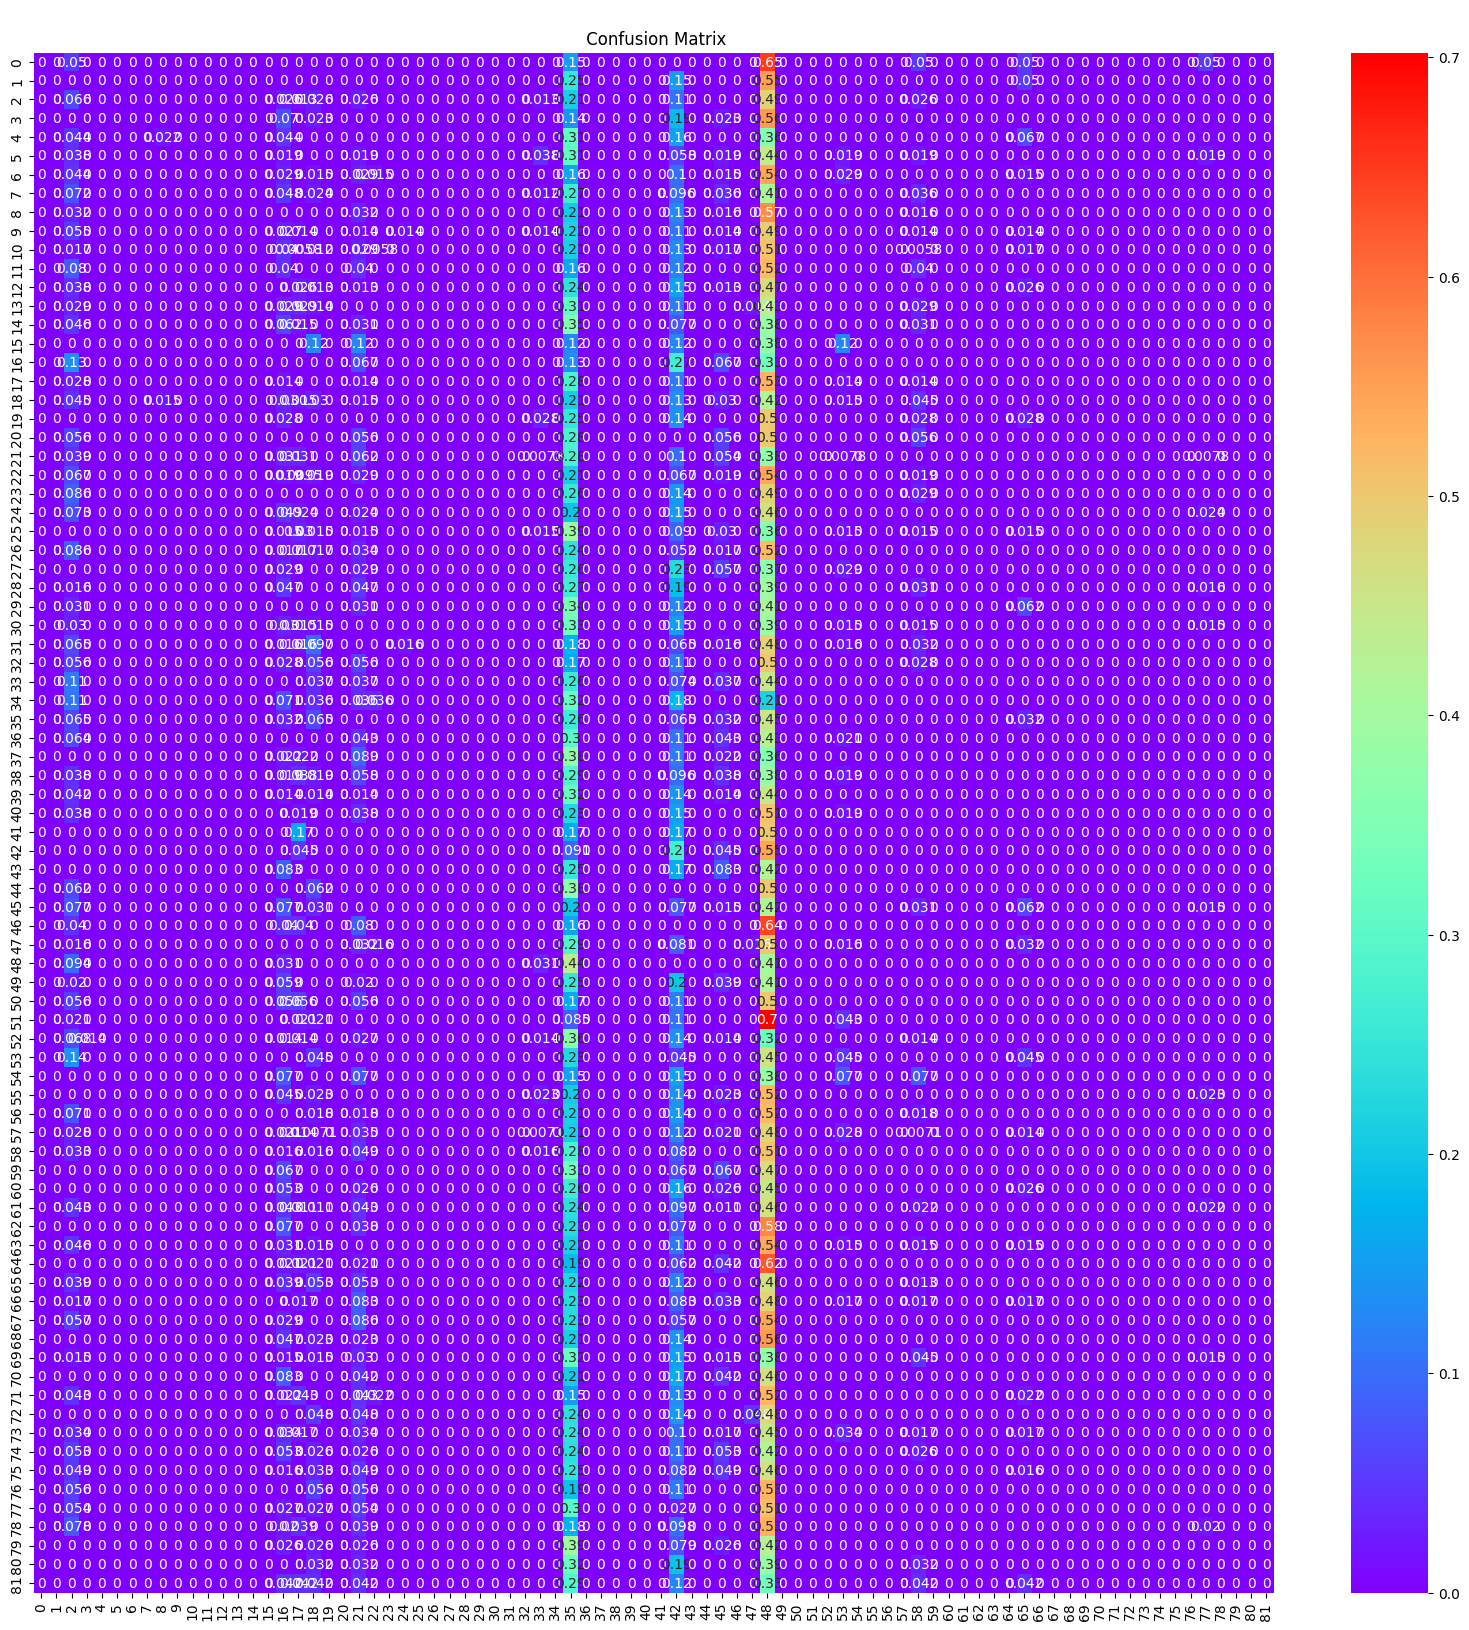

In [34]:
model_analysis(model, val_dataloader)

In [16]:
plt.figure(figsize=(12,12))
plt.show()

<Figure size 1200x1200 with 0 Axes>